# Multi-Template matching 
## Tutorial 2 : template "augmentation"

In this tutorial we will use the multi-template matching to localize fish embryos in wells of a 96 well plate.
The embryos are circular and thus their position and orientation is completely random. We could possibly use segmentation to localize them but template matching is a possible option too.

We are going to use a published dataset available on Zenodo (thanks Jakob ;) )  
Just click the DOI badge below.
 [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.2650147.svg)](https://doi.org/10.5281/zenodo.2650147)
 
 ----------------------------------------
 
<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This tutorial is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.  
You are free to distribute and/or modify this tutorial, provided you attribute the author:  

Multi-Template Matching python package online tutorial - _Tutorial 2: Template Augmentation_  
Laurent Thomas - 2019   
https://github.com/multi-template-matching/MultiTemplateMatching-Python/blob/master/tutorials/Tutorial2-Template_Augmentation.ipynb

## Let's code !

In [3]:
# 1st import the package and check its version
import MTM
print("MTM version : ", MTM.__version__)

from MTM import matchTemplates, drawBoxesOnRGB

import cv2
from skimage import io
import matplotlib.pyplot as plt
import numpy as np

MTM version :  1.15.1


Let's open one image from the Zenodo repo using scikit-image

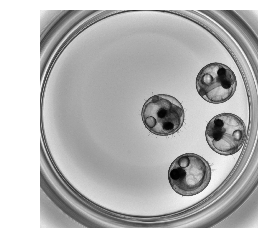

In [4]:
URL = r"https://zenodo.org/record/2650147/files/WE00049---E001--PO01--LO001--CO6--00000000_00.01.00_00.16.00%2C000.jpg"
image = io.imread(URL)
plt.axis("off")
plt.imshow(image, cmap="gray")

Let's crop one of the egg to use as a template

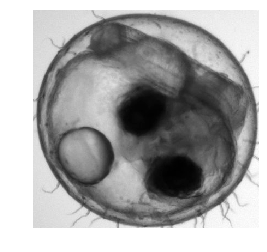

In [5]:
temp0 = image[784:784+400, 946:946+414] # with well 49 
plt.axis("off")
plt.imshow(temp0, cmap="gray")

We can now call `matchTemplates` with this single template image 

In [6]:
# 1st format the template into a list of tuple (label, templateImage)
listTemplate = [('temp0', temp0)]

# Then call the function matchTemplates (here a single template)
Hits = matchTemplates(listTemplate, image, N_object=4,score_threshold=0.4, method=cv2.TM_CCOEFF_NORMED, maxOverlap=0.3)

We know in this particular experience the number of object in each image, we can thus set `N_objects=4`.  

Then because the eggs are sometimes touching each others, the rectangular predicted locations might slightly overlap between the different eggs.  
In the same time we dont want to have 2 bounding boxes that match the same egg.  
That's why we set `maxOverlap=0.25` meaning that the ratio between the intersection and union area between 2 bounding boxes is allowed to be maximum 25%.    

Let's have a look at `Hits`...

In [7]:
print("Found {} hits".format( len(Hits.index) ) )
print(Hits)

Found 4 hits
                     BBox     Score TemplateName
0    [946, 784, 414, 400]  1.000000        temp0
1   [1398, 889, 414, 400]  0.512312        temp0
2   [1438, 481, 414, 400]  0.472887        temp0
3  [1064, 1238, 414, 400]  0.461289        temp0


As you can see, `Hits` is a table (pandas DataFrame) with one row per detection with:
- the name of the template that yield the match
- the coordinates of the bounding box (x, y, width, height)
- the score for that detection  

The first hit in the list has a score of 1 and is the egg that is used as template.

We can then represent the detections as bounding boxes overlaid on the image, with a tag for the label.

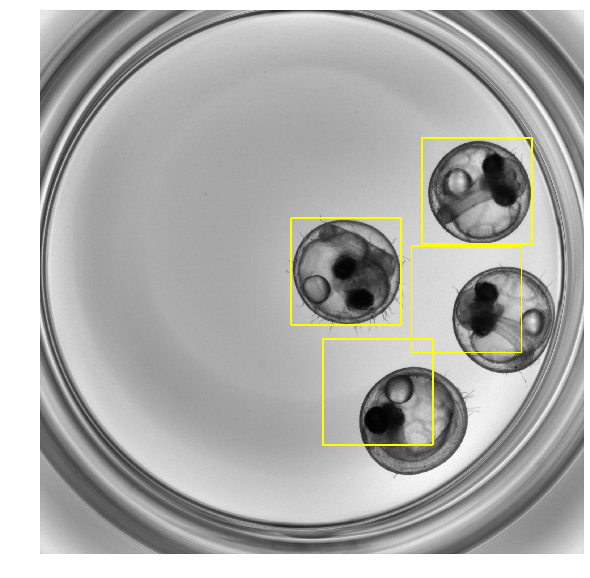

In [8]:
Overlay = drawBoxesOnRGB(image, Hits, boxThickness=5)
plt.figure(figsize = (10,10))
plt.axis("off")
plt.imshow(Overlay)

2 out of 4 eggs are enclosed within the detected regions.  
This is due to the fact that the template matching matches intensity patterns, ie it will properly find objects that have the same orientation and perspective as in the template.  
To improve the precision of localisation, one can provide more templates (other perspectives...) to search.  

The additional templates can be generated by rotation or flipped (mirroring) of the initial template. This is a bit like doing data-augmentation but on the template side.  

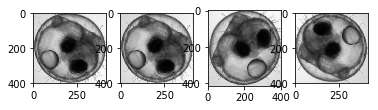

In [9]:
## Perform rotation of the initial template
listTemplate = [("0", temp0)]

# Initialise figure
f, axarr = plt.subplots(1,4)
axarr[0].imshow(temp0, cmap="gray")

for i,angle in enumerate([90,180,270]):
    rotated = np.rot90(temp0, k=i) # NB: rotate not good here, turns into float!
    listTemplate.append( (str(angle), rotated ) )
    axarr[i+1].imshow(rotated, cmap="gray")
    
    # We could also do some flipping with np.fliplr, flipud

We now have 4 templates from the initial template.  
We can search each of them and still return the 4 best matches.

                     BBox     Score TemplateName
0    [946, 784, 414, 400]  1.000000            0
1   [1525, 968, 414, 400]  0.591937          270
2  [1173, 1354, 414, 400]  0.551068          270
3   [1459, 474, 400, 414]  0.538105          180


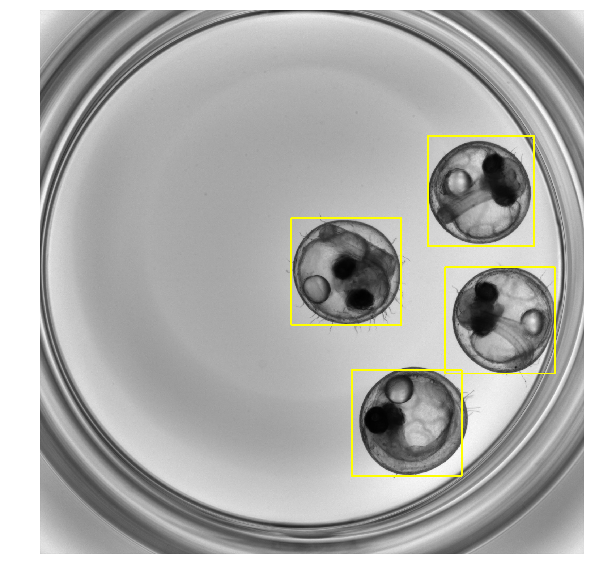

In [10]:
Hits = matchTemplates(listTemplate, image, N_object=4, score_threshold=0.4, method=cv2.TM_CCOEFF_NORMED, maxOverlap=0.3)
    
Overlay = drawBoxesOnRGB(image, Hits, boxThickness=5)
plt.figure(figsize = (10,10))
plt.axis("off")
plt.imshow(Overlay)

print(Hits)

As you can see, the accuracy of the localisation has improved and indeed for those 4 new hits, 3 of them are from rotated versions of the template.

Et voila !  
Using several templates can be used to increase the chance to catch your object if it appears with different perspectives, or to perform classification of the detections using different templates as "classes".  
However, the more templates the longer the computation time.